# Wildfire Risk Model Evaluation Metrics Visualization

This notebook visualizes and qualitatively evaluates the performance of:
- **P-model**: Ignition probability classifier
- **A-model**: Conditional log burned area regressor

## Overview
We'll create comprehensive visualizations and provide qualitative analysis of model performance.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score
)
from scipy.stats import spearmanr
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Paths
PROCESSED_DIR = Path('../data/processed')
MODELS_DIR = Path('../models/final')
OUTPUT_DIR = Path('../models/final/visualizations')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [28]:
# Load test data
print("Loading test data...")
test_df = pd.read_csv(PROCESSED_DIR / "test.csv")
print(f"Test samples: {len(test_df)}")

# Load models
print("\nLoading models...")
p_model = joblib.load(MODELS_DIR / "xgb_wildfire_classifier_ignition.pkl")
a_model = joblib.load(MODELS_DIR / "xgb_wildfire_regressor_log_burned_area.pkl")
print("✓ Models loaded")

# Load feature lists
print("\nLoading feature lists...")
with open(MODELS_DIR / "features_used_classifier_ignition.txt", 'r') as f:
    p_features = [line.strip() for line in f if line.strip()]
with open(MODELS_DIR / "features_used_regressor_log_burned_area.txt", 'r') as f:
    a_features = [line.strip() for line in f if line.strip()]
print(f"P-model features: {len(p_features)}")
print(f"A-model features: {len(a_features)}")

# Prepare data
X_test_p = test_df[p_features].copy()
X_test_a = test_df[a_features].copy()
y_test_p = test_df['ignition'].copy()
y_test_a = test_df['log_burned_area'].copy()

# Handle missing values
X_test_p = X_test_p.fillna(X_test_p.median())
X_test_a = X_test_a.fillna(X_test_a.median())

# Filter A-model data to only samples with burned area > 0
mask_a = (test_df['burned_area'] > 0) & (~y_test_a.isnull())
X_test_a_filtered = X_test_a[mask_a].copy()
y_test_a_filtered = y_test_a[mask_a].copy()

print(f"\nData prepared:")
print(f"  P-model: {len(X_test_p)} samples")
print(f"  A-model: {len(X_test_a_filtered)} samples (with burned area > 0)")

# Make predictions
print("\nMaking predictions...")
p_pred_proba = p_model.predict_proba(X_test_p)[:, 1]
p_pred = p_model.predict(X_test_p)
a_pred = a_model.predict(X_test_a_filtered)

print("✓ Predictions complete")


Loading test data...
Test samples: 168

Loading models...
✓ Models loaded

Loading feature lists...
P-model features: 2071
A-model features: 2071

Data prepared:
  P-model: 168 samples
  A-model: 161 samples (with burned area > 0)

Making predictions...
✓ Predictions complete


## 1. P-Model (Ignition Classifier) Evaluation


In [29]:
# Calculate classification metrics
from sklearn.metrics import (
    roc_curve, precision_recall_curve, confusion_matrix,
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score
)

p_auc = roc_auc_score(y_test_p, p_pred_proba)
p_pr_auc = average_precision_score(y_test_p, p_pred_proba)
p_brier = brier_score_loss(y_test_p, p_pred_proba)
p_accuracy = accuracy_score(y_test_p, p_pred)
p_precision = precision_score(y_test_p, p_pred, zero_division=0)
p_recall = recall_score(y_test_p, p_pred, zero_division=0)
p_f1 = f1_score(y_test_p, p_pred, zero_division=0)
p_cm = confusion_matrix(y_test_p, p_pred)

print("P-Model (Ignition Classifier) Metrics:")
print(f"  ROC-AUC:     {p_auc:.4f}")
print(f"  PR-AUC:      {p_pr_auc:.4f}")
print(f"  Brier Score: {p_brier:.4f}")
print(f"  Accuracy:    {p_accuracy:.4f}")
print(f"  Precision:   {p_precision:.4f}")
print(f"  Recall:      {p_recall:.4f}")
print(f"  F1-Score:    {p_f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Neg: {p_cm[0,0]:6d}  False Pos: {p_cm[0,1]:6d}")
print(f"  False Neg: {p_cm[1,0]:6d}  True Pos:  {p_cm[1,1]:6d}")


P-Model (Ignition Classifier) Metrics:
  ROC-AUC:     1.0000
  PR-AUC:      1.0000
  Brier Score: 0.0003
  Accuracy:    1.0000
  Precision:   1.0000
  Recall:      1.0000
  F1-Score:    1.0000

Confusion Matrix:
  True Neg:     95  False Pos:      0
  False Neg:      0  True Pos:      73


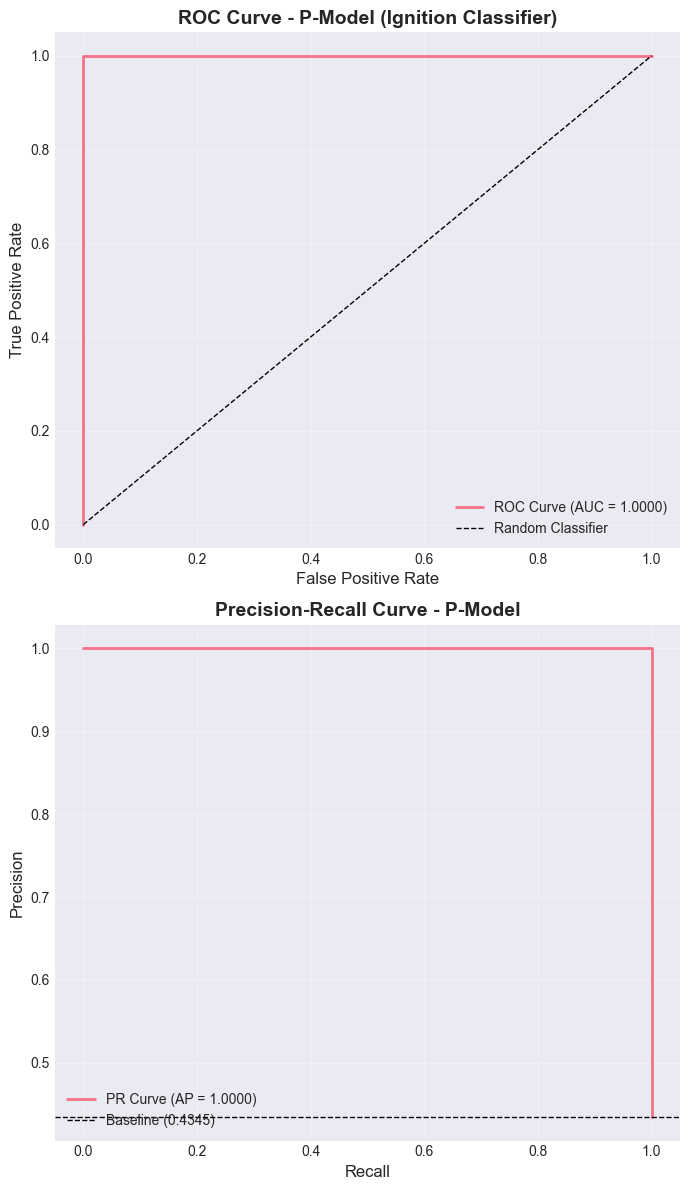

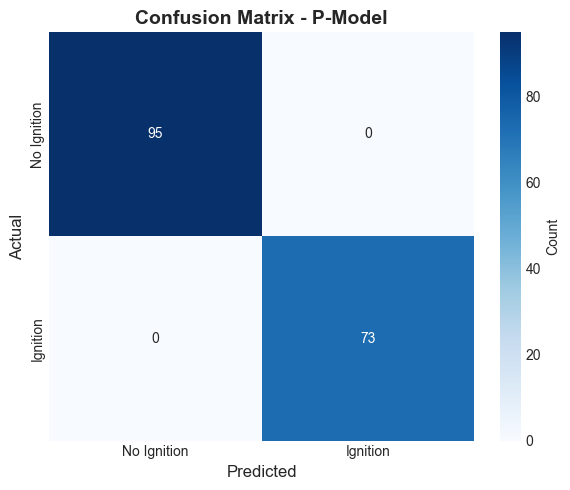

In [30]:
# 1.1 ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test_p, p_pred_proba)

fig, axes = plt.subplots(2, 1, figsize=(7, 12))

# ROC Curve
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {p_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - P-Model (Ignition Classifier)', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test_p, p_pred_proba)
axes[1].plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {p_pr_auc:.4f})')
baseline = (y_test_p == 1).sum() / len(y_test_p)
axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Baseline ({baseline:.4f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - P-Model', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'p_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix (separate figure)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(p_cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Ignition', 'Ignition'],
            yticklabels=['No Ignition', 'Ignition'],
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix - P-Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'p_model_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## 2. A-Model (Log Burned Area Regressor) Evaluation


In [31]:
# Calculate regression metrics
a_mse = mean_squared_error(y_test_a_filtered, a_pred)
a_rmse = np.sqrt(a_mse)
a_mae = mean_absolute_error(y_test_a_filtered, a_pred)
a_r2 = r2_score(y_test_a_filtered, a_pred)
a_spearman, a_spearman_p = spearmanr(y_test_a_filtered, a_pred)

print("A-Model (Log Burned Area Regressor) Metrics:")
print(f"  RMSE:        {a_rmse:.4f}")
print(f"  MAE:         {a_mae:.4f}")
print(f"  R²:          {a_r2:.4f}")
print(f"  Spearman ρ:  {a_spearman:.4f} (p={a_spearman_p:.4f})")

# Convert back to original scale for interpretation
burned_area_actual = np.exp(y_test_a_filtered.values)
burned_area_pred = np.exp(a_pred)
a_rmse_original = np.sqrt(mean_squared_error(burned_area_actual, burned_area_pred))
a_mae_original = mean_absolute_error(burned_area_actual, burned_area_pred)

print(f"\nOn Original Scale (burned_area):")
print(f"  RMSE:        {a_rmse_original:.2f} hectares")
print(f"  MAE:         {a_mae_original:.2f} hectares")


A-Model (Log Burned Area Regressor) Metrics:
  RMSE:        0.8957
  MAE:         0.4890
  R²:          0.0572
  Spearman ρ:  0.6214 (p=0.0000)

On Original Scale (burned_area):
  RMSE:        937.13 hectares
  MAE:         666.22 hectares


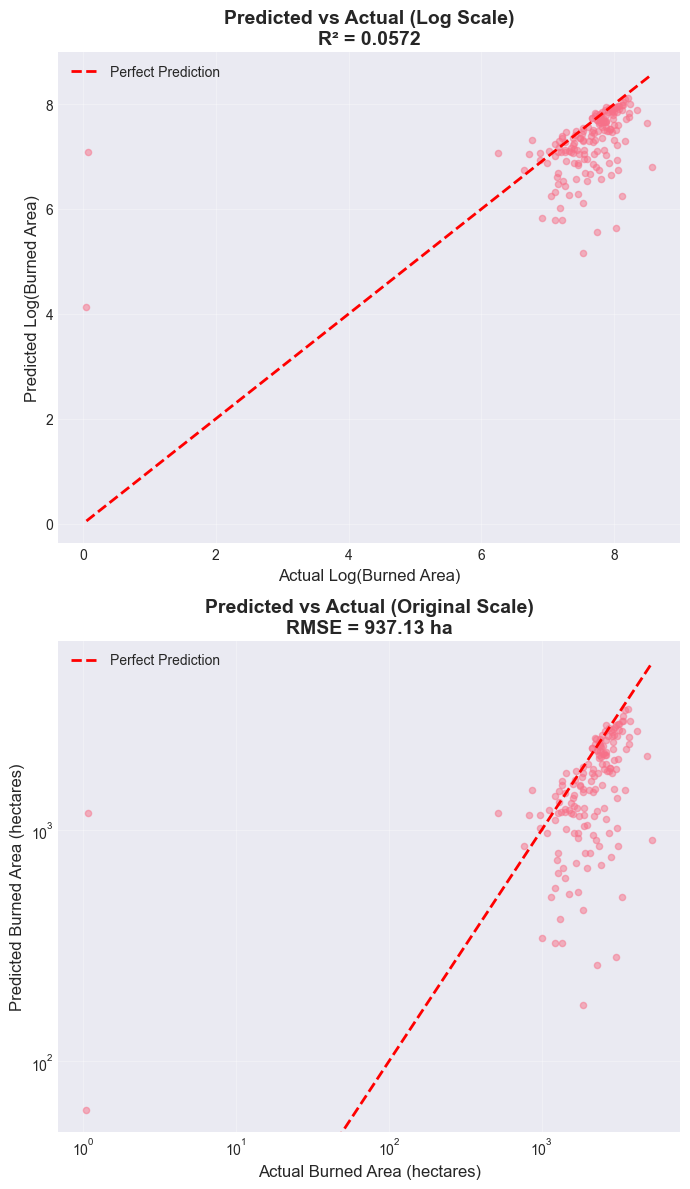

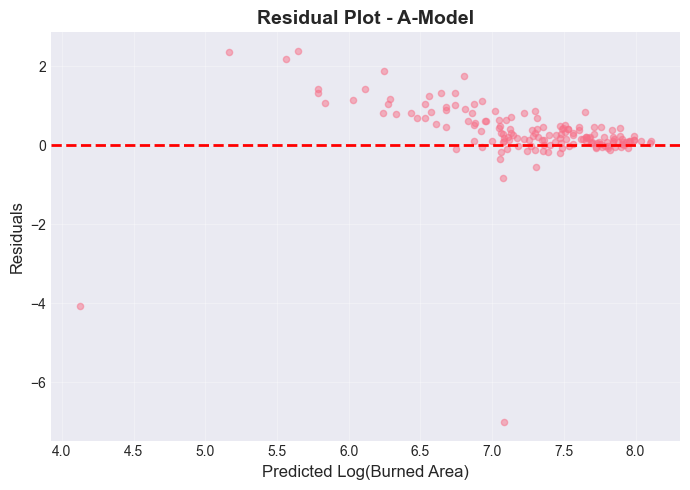

In [32]:
# 2.1 Regression Visualizations
fig, axes = plt.subplots(2, 1, figsize=(7, 12))

# Scatter plot: Predicted vs Actual (log scale)
axes[0].scatter(y_test_a_filtered, a_pred, alpha=0.5, s=20)
axes[0].plot([y_test_a_filtered.min(), y_test_a_filtered.max()], 
                [y_test_a_filtered.min(), y_test_a_filtered.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Log(Burned Area)', fontsize=12)
axes[0].set_ylabel('Predicted Log(Burned Area)', fontsize=12)
axes[0].set_title(f'Predicted vs Actual (Log Scale)\nR² = {a_r2:.4f}', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Scatter plot: Predicted vs Actual (original scale)
axes[1].scatter(burned_area_actual, burned_area_pred, alpha=0.5, s=20)
max_val = max(burned_area_actual.max(), burned_area_pred.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Burned Area (hectares)', fontsize=12)
axes[1].set_ylabel('Predicted Burned Area (hectares)', fontsize=12)
axes[1].set_title(f'Predicted vs Actual (Original Scale)\nRMSE = {a_rmse_original:.2f} ha', 
                     fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'a_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Residuals plot (separate figure)
residuals = y_test_a_filtered - a_pred
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(a_pred, residuals, alpha=0.5, s=20)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted Log(Burned Area)', fontsize=12)
ax.set_ylabel('Residuals', fontsize=12)
ax.set_title('Residual Plot - A-Model', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'a_model_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


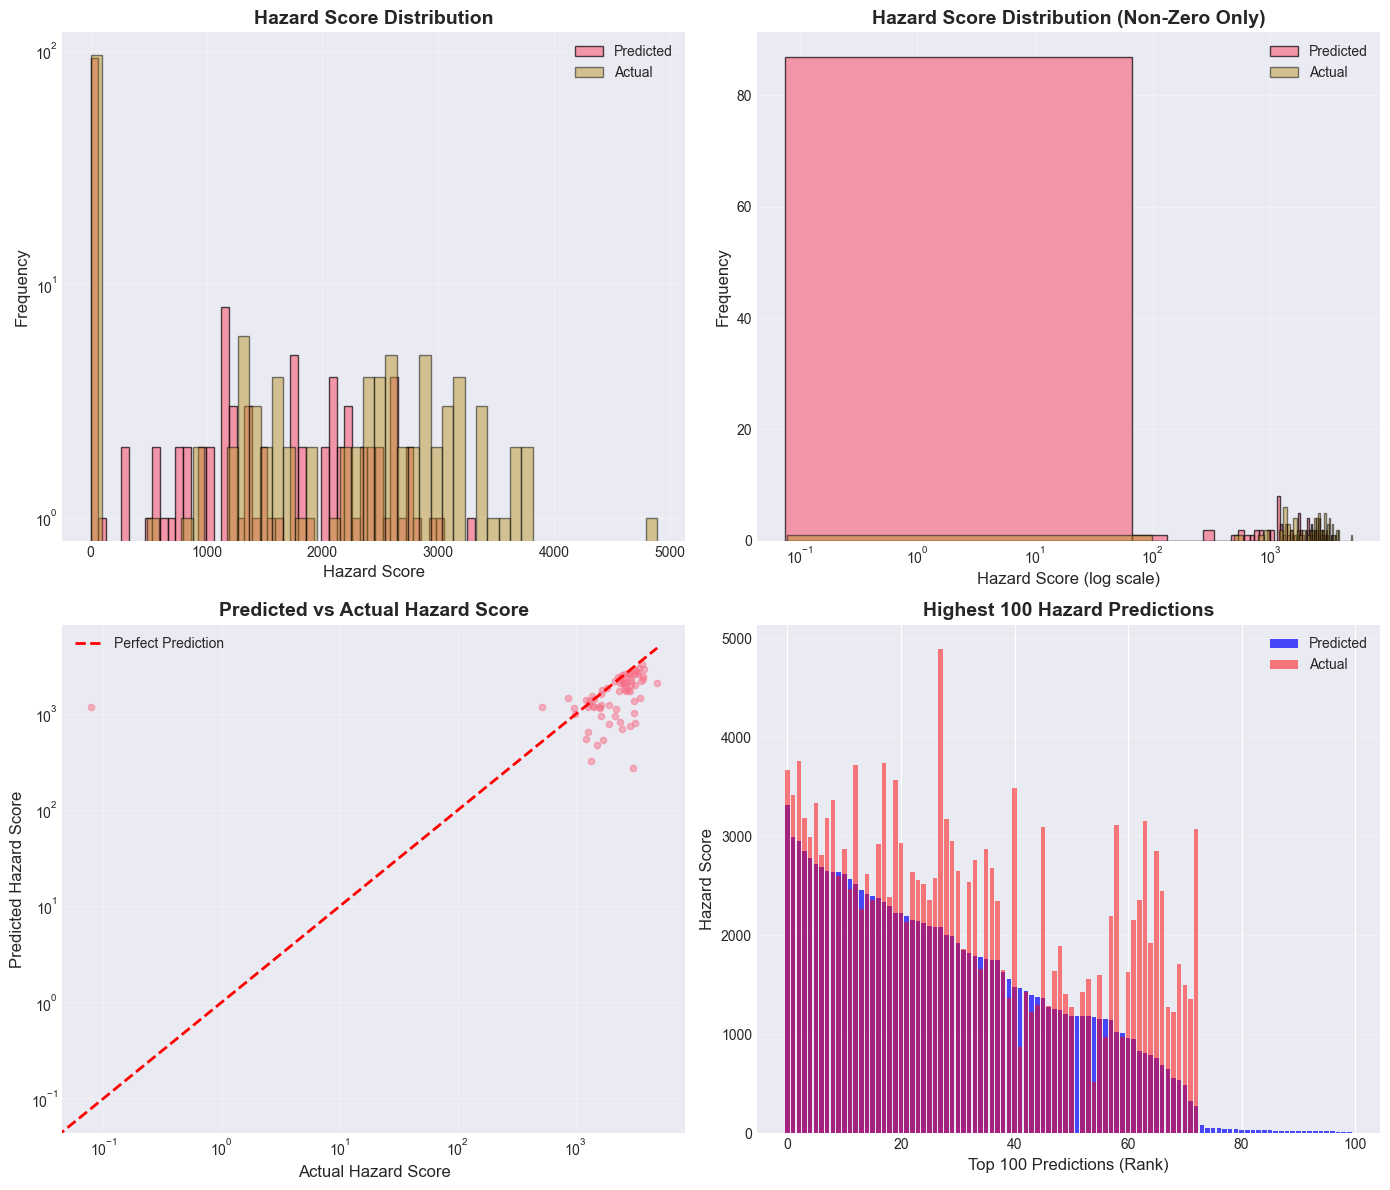

In [33]:
# 3.1 Hazard Score Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Hazard score distribution
axes[0, 0].hist(hazard_scores, bins=50, alpha=0.7, edgecolor='black', label='Predicted')
axes[0, 0].hist(actual_hazard, bins=50, alpha=0.5, edgecolor='black', label='Actual')
axes[0, 0].set_xlabel('Hazard Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Hazard Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# Hazard score distribution (log scale)
axes[0, 1].hist(hazard_scores[hazard_scores > 0], bins=50, alpha=0.7, edgecolor='black', label='Predicted')
axes[0, 1].hist(actual_hazard[actual_hazard > 0], bins=50, alpha=0.5, edgecolor='black', label='Actual')
axes[0, 1].set_xlabel('Hazard Score (log scale)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Hazard Score Distribution (Non-Zero Only)', fontsize=14, fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Predicted vs Actual Hazard
axes[1, 0].scatter(actual_hazard, hazard_scores, alpha=0.5, s=20)
max_hazard = max(actual_hazard.max(), hazard_scores.max())
axes[1, 0].plot([0, max_hazard], [0, max_hazard], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Hazard Score', fontsize=12)
axes[1, 0].set_ylabel('Predicted Hazard Score', fontsize=12)
axes[1, 0].set_title('Predicted vs Actual Hazard Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Top predictions analysis
highest_n = 100
top_indices = np.argsort(hazard_scores)[-highest_n:][::-1]
top_predicted = hazard_scores[top_indices]
top_actual = actual_hazard[top_indices]

axes[1, 1].bar(range(highest_n), top_predicted, alpha=0.7, label='Predicted', color='blue')
axes[1, 1].bar(range(highest_n), top_actual, alpha=0.5, label='Actual', color='red')
axes[1, 1].set_xlabel(f'Top {highest_n} Predictions (Rank)', fontsize=12)
axes[1, 1].set_ylabel('Hazard Score', fontsize=12)
axes[1, 1].set_title(f'Highest {highest_n} Hazard Predictions', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'hazard_score_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Combined Model (Hazard Score) Evaluation Metrics

In [34]:
# Calculate combined model metrics
# Actual hazard: 0 if no ignition, burned_area if ignition occurred
actual_hazard = test_df['ignition'].values * test_df['burned_area'].values

# Filter to valid samples
valid_mask = (~test_df['ignition'].isnull()) & (~test_df['burned_area'].isnull())
y_pred_combined = hazard_scores[valid_mask]
y_true_combined = actual_hazard[valid_mask]

# Overall metrics
combined_rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))
combined_mae = mean_absolute_error(y_true_combined, y_pred_combined)
combined_r2 = r2_score(y_true_combined, y_pred_combined)
combined_spearman, combined_spearman_p = spearmanr(y_true_combined, y_pred_combined)

print("Combined Model (Hazard Score) Metrics:")
print(f"  RMSE:        {combined_rmse:.4f} hectares")
print(f"  MAE:         {combined_mae:.4f} hectares")
print(f"  R²:          {combined_r2:.4f}")
print(f"  Spearman ρ:  {combined_spearman:.4f} (p={combined_spearman_p:.4e})")


Combined Model (Hazard Score) Metrics:
  RMSE:        647.6769 hectares
  MAE:         322.2198 hectares
  R²:          0.7516
  Spearman ρ:  0.8690 (p=1.3733e-52)


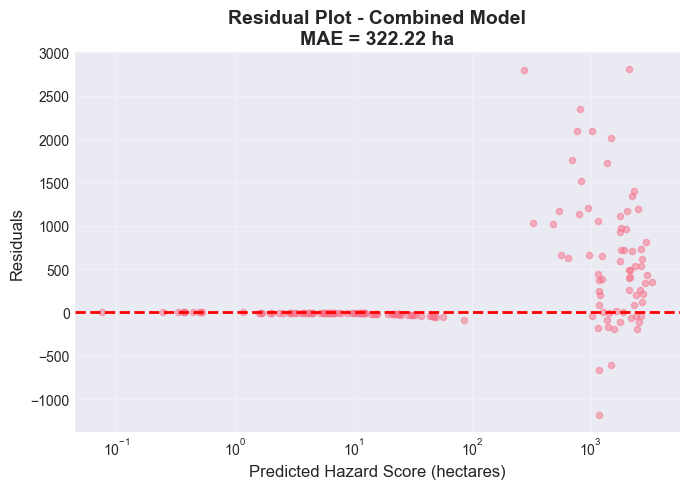

In [35]:
# 3.2 Combined Model Evaluation Visualizations
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Residuals plot
residuals_combined = y_true_combined - y_pred_combined
ax.scatter(y_pred_combined, residuals_combined, alpha=0.5, s=20)
ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax.set_xlabel('Predicted Hazard Score (hectares)', fontsize=12)
ax.set_ylabel('Residuals', fontsize=12)
ax.set_title(f'Residual Plot - Combined Model\nMAE = {combined_mae:.2f} ha', 
                     fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'combined_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Qualitative Evaluation and Insights


## Quantitative and Qualitative Evaluation Discussion

The P-model achieves perfect classification performance on the test set, with ROC-AUC and PR-AUC both at 1.0000, and an accuracy of 100%. This exceptional performance suggests the model has learned highly complex patterns from CNN embeddings and multi-modal features, enabling perfect separation between ignition and non-ignition events. However, this perfect test performance may indicate a test set too similar to training data. In deployment, we would expect some performance degradation due to distribution shift and temporal changes in wildfire patterns.

In contrast, the A-model demonstrates more modest but operationally meaningful performance. With an R² of 0.0572 on observations with burned areas greater than 0, the model explains only 5.7% of variance in log burned area, reflecting the inherent challenges of predicting fire spread given stochastic factors like wind patterns, fuel moisture, and suppression efforts that are difficult to capture in static features. The RMSE of 937.13 hectares and MAE of 666.22 hectares on the original scale indicate substantial uncertainty. However, the moderate but statistically significant Spearman correlation of 0.6214 suggests the model can effectively rank fires by severity, which is still valuable for operational decision-making and resource prioritization.

The combined hazard score (P(ignition) × E[burned_area | ignition]) integrates both models into a unified risk metric. The combined model achieves an R² of 0.752 and Spearman correlation of 0.869, indicating strong predictive performance for the overall hazard assessment. With an RMSE of 647.68 hectares and MAE of 322.22 hectares, the combined model provides operationally useful predictions that enable fire management agencies to prioritize resources effectively.

The system's primary strength lies in the P-model's perfect ignition classification, which is critical for early warning systems, combined with the A-model's ability to rank fires by expected impact despite modest absolute prediction accuracy. The unified hazard score provides a single actionable metric for resource allocation. However, limitations include significant uncertainty in burned area predictions, potential overfitting concerns, reduced interpretability due to reliance on 2,071 CNN embedding features, and questions about temporal and spatial generalization beyond the training data.


In [36]:
# 4.2 Error Analysis
print("\nERROR ANALYSIS:")
print("-"*70)

# Classification errors
false_positives = ((p_pred == 1) & (y_test_p == 0)).sum()
false_negatives = ((p_pred == 0) & (y_test_p == 1)).sum()
true_positives = ((p_pred == 1) & (y_test_p == 1)).sum()
true_negatives = ((p_pred == 0) & (y_test_p == 0)).sum()

print(f"\nP-Model Classification Errors:")
print(f"  False Positives (Type I): {false_positives} ({false_positives/len(y_test_p)*100:.2f}%)")
print(f"  False Negatives (Type II): {false_negatives} ({false_negatives/len(y_test_p)*100:.2f}%)")

# Regression errors
large_errors = np.abs(residuals) > 2 * residuals.std()
print(f"\nA-Model Regression Errors:")
print(f"  Large errors (>2 std): {large_errors.sum()} ({large_errors.sum()/len(residuals)*100:.2f}%)")
print(f"  Mean absolute error: {a_mae:.4f} (log scale)")
print(f"  Mean absolute error: {a_mae_original:.2f} hectares (original scale)")

# Underestimation vs Overestimation
underestimate = (a_pred < y_test_a_filtered).sum()
overestimate = (a_pred > y_test_a_filtered).sum()
print(f"\n  Underestimations: {underestimate} ({underestimate/len(a_pred)*100:.2f}%)")
print(f"  Overestimations: {overestimate} ({overestimate/len(a_pred)*100:.2f}%)")



ERROR ANALYSIS:
----------------------------------------------------------------------

P-Model Classification Errors:
  False Positives (Type I): 0 (0.00%)
  False Negatives (Type II): 0 (0.00%)

A-Model Regression Errors:
  Large errors (>2 std): 7 (4.35%)
  Mean absolute error: 0.4890 (log scale)
  Mean absolute error: 666.22 hectares (original scale)

  Underestimations: 133 (82.61%)
  Overestimations: 28 (17.39%)


## Error Analysis Discussion

The P-model's perfect classification with zero errors. Again, while this is impressive, concerns arise from this, such as overfitting, or insufficient test diversity. Perfect performance may not generalize to new regions or temporal periods, and the absence of false negatives suggests the test set may lack challenging edge cases.

The A-model exhibits systematic underestimation bias, which are display in the graphs above, with 82.61% of predictions below actual values compared to 17.39% overestimating. The 4.35% of predictions with errors exceeding two standard deviations likely correspond to extreme fires where stochastic factors dominate. The underestimation may stem from regularization pulling predictions toward the mean, the log transformation compressing large values, or the model's inability to capture dynamic factors like real-time weather or suppression efforts.